# Car price prediction

The service for the sale of used cars "Not beaten, not painted" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. Historical data is at our disposal: technical specifications, complete sets and prices of cars. We need to build a model to determine the cost. 

Important to the customer:

- prediction quality;
- prediction speed;
- training time.

**Data description**


The data is in the auto.csv


**Features**


DateCrawled — date of downloading the questionnaire from the database


VehicleType — type of car body


RegistrationYear — the year of registration of the car


Gearbox — type of gearbox


Power — power (hp)


Model — car model


Kilometer — mileage (km)


RegistrationMonth — month of car registration


FuelType — fuel type


Brand — car brand


NotRepaired — was the car under repair or not


DateCreated — date of creation of the questionnaire


NumberOfPictures — the number of photos of the car


PostalCode — postal code of the questionnaire owner (user)


lastSeen — the date of the user's last activity


**Target**


Price — price (Euro)

## 1. Data preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import time
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from catboost import CatBoostRegressor, Pool
import lightgbm
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as RSquared
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('autos.csv')

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Since not all the features from the original dataset are relevant for subsequent research, we will leave the following in the dataset:

VahicleType - the type of car body determines the labor costs for this car, its intended use, which will significantly affect its cost;

RegistrationYear - the age of the car affects its cost inversely (as a general rule). The above does not apply to vintage cars;

Gearbox - the type of gearbox, as a rule, determines the demand for a specific car model, respectively, and its price;

Power - as a general rule: more powerful cars have a higher cost

Model - the type of model can directly affect the cost due to increasing demand, for example, for a coupe

Kilometer - One of the ways to determine the warranty period is mileage. Accordingly, the car subject to warranty service (with less mileage) should have a higher cost

FuelType - the type of fuel determines its consumption, availability in a certain region, which significantly affects the cost of the car

Brand - there are special ratings for determining the value of brands, respectively, cars of the same type classes, but different brands have different costs;

NotRepaired - the presence of repairs may mean that the car is in an accident, therefore significantly reduce its cost, therefore it should be included among the significant features

In [4]:
df_filtered = df.drop(['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

df_filtered.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Remove full duplicates from the filtered dataframe.

In [5]:
print(f'Filtered dataset contains {df_filtered.duplicated().sum()} complete duplicates which constitute {round(df_filtered.duplicated().sum() / len(df_filtered) * 100, 1)}%')

df_filtered.shape

Filtered dataset contains 45040 complete duplicates which constitute 12.7%


(354369, 10)

In [6]:
df_filtered1 = df_filtered.drop_duplicates().reset_index(drop=True)

df_filtered1.shape

(309329, 10)

In [7]:
# Let's create a temporary dictionary for the convenience of the initial data analysis
df_general = {}
for name in df_filtered1.columns:
    col_name = f'{name}'
    df_general[col_name] = df_filtered1[col_name]

Let's check for missing values. If the specified values exceed 3%, then it will be necessary to apply special methods to eliminate deviations, otherwise, the specified lines will simply be deleted (if available).

In [8]:
# Let's check for missing values, duplicates, outliers and inadequate values in each of the columns
def general_info(name, value, isna_col, isna_col2):
    print()
    number = df[name].isna().sum()
    percent = round(number / len(value), 2) * 100
    if percent >= 3:
        print(f'In {name} columns there are - {number} rows with missing values which constitute {percent} %')
        isna_col.append(name)
    elif percent > 0:
        isna_col2.append(name)
    return isna_col    

# list for saving the names of columns that require editing due to missing values
isna_col = []
isna_col2 = []
for name,value in df_general.items():
    isna_col = general_info(name, value,isna_col, isna_col2)

    
print('Columns that require the elimination of missing values by special methods',isna_col)
print()
print('Columns requiring elimination of missing values by deleting rows',isna_col2)



In VehicleType columns there are - 37490 rows with missing values which constitute 12.0 %


In Gearbox columns there are - 19833 rows with missing values which constitute 6.0 %


In Model columns there are - 19705 rows with missing values which constitute 6.0 %


In FuelType columns there are - 32895 rows with missing values which constitute 11.0 %


In NotRepaired columns there are - 71154 rows with missing values which constitute 23.0 %
Columns that require the elimination of missing values by special methods ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

Columns requiring elimination of missing values by deleting rows []


count    309329.000000
mean       2004.360105
std          92.541399
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

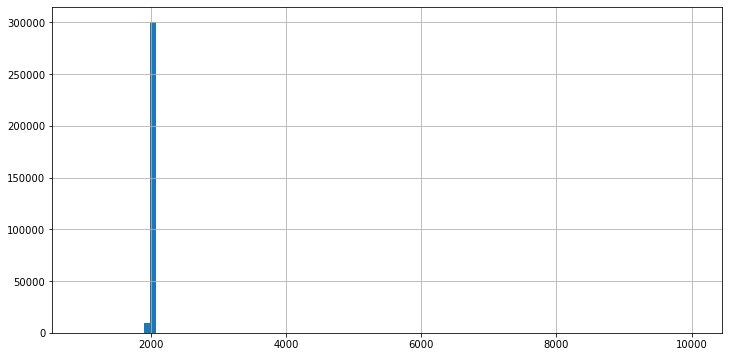

In [9]:
df_filtered1.RegistrationYear.hist(bins=100, figsize=(12,6))
df_filtered1.RegistrationYear.describe()

In [10]:
df_filtered1.RegistrationYear.describe()

count    309329.000000
mean       2004.360105
std          92.541399
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Outliers are observed in the RegistrationYear column: the minimum value is 1000, the maximum is 9999. Given that the first cars intended for mass use appeared already at the beginning of the 20th century, and the current year is 2022, then further research should determine the amount of outliers (i.e. cars that appeared earlier than 1900 and existing later than 2022) and, if necessary, remove them.

In [11]:
print(df_filtered1.query('(1900 > RegistrationYear) or (RegistrationYear > 2022)').count()['RegistrationYear'])

162


In [12]:
df_filtered1.query('(1900 > RegistrationYear) or (RegistrationYear > 2022)').head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
12836,49,NaN,5000,NaN,0,golf,5000,NaN,volkswagen,NaN
15000,0,NaN,9999,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
15702,1700,NaN,3200,NaN,0,NaN,5000,NaN,sonstige_autos,NaN
15888,190,NaN,1000,NaN,0,mondeo,5000,NaN,ford,NaN


Delete the rows with outliers in the RegistrationYear column.

In [13]:
df_filtered2 = df_filtered1.query('(1900 <= RegistrationYear) and (RegistrationYear <= 2022)')

df_filtered2.shape

(309167, 10)

In [14]:
df_filtered2.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<AxesSubplot:>

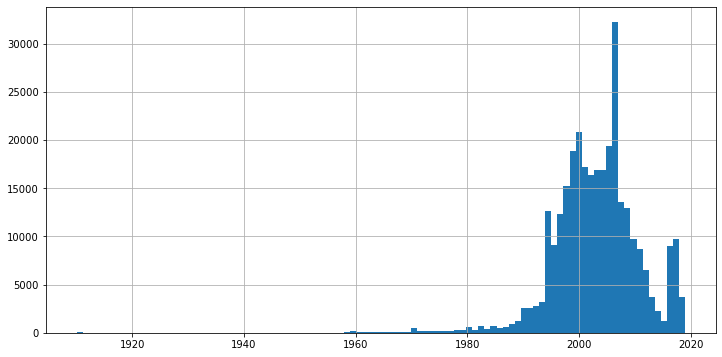

In [15]:
df_filtered2.RegistrationYear.hist(bins=100, figsize=(12,6))

Let's analyze the right boundary of our car distribution by registration date.

In [16]:
date = pd.to_datetime(df.DateCrawled)
date.max()

Timestamp('2016-04-07 14:36:58')

Since the latest date of downloading the questionnaire from the database dates back to 2016, all positions of cars registered later than this date are incorrect and should be deleted.

In [17]:
df_filtered2 = df_filtered1.query('(1900 <= RegistrationYear) and (RegistrationYear <= 2016)')

df_filtered2.shape

(295675, 10)

In [18]:
# Let's check for missing values in the target column
df_filtered2.Price.isna().sum()

0

Since the rows with the cost of cars equal to 0 do not represent value (they do not allow predicting the cost of a car with specific parameters on the secondary market), we will delete the rows with 0 price value.

In [19]:
print(df_filtered2.query('Price == 0').count()['Price'])

8221


In [20]:
df_filtered3 = df_filtered2.query('Price > 0')
df_filtered3.shape

(287454, 10)

<AxesSubplot:>

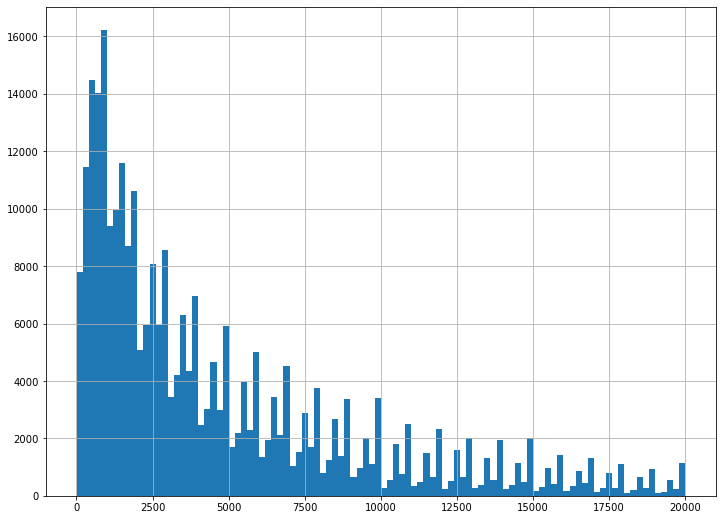

In [21]:
df_filtered3.Price.hist(bins=100,figsize=(12,9))

Taking into account the nature of the distribution (the presence of a large number of outliers on the right, as well as a large number of values close to 0), we will leave a 90% confidence interval.

In [22]:
print(df_filtered3.Price.quantile([0.05, 0.95]))

0.05      350.0
0.95    14990.0
Name: Price, dtype: float64


In [23]:
df_filtered3 = df_filtered3.query('350 <= Price <= 14990')
df_filtered3.shape

(259267, 10)

In [24]:
df_filtered3.Price.describe()

count    259267.000000
mean       4221.442791
std        3638.493653
min         350.000000
25%        1300.000000
50%        2990.000000
75%        6200.000000
max       14990.000000
Name: Price, dtype: float64

Let's fill in missing values in VehicleType, Gearbox, Model, FuelType, NotRepaired columns.

In [25]:
df_filtered3.Gearbox.isna().sum()

10928

In [26]:
df_filtered3.Gearbox.value_counts()

manual    199269
auto       49070
Name: Gearbox, dtype: int64

In [27]:
print(round(df_filtered3.query("Gearbox == 'manual'").count()['Gearbox'] / len(df_filtered3) * 100,2))

76.86


In [28]:
print(round(df_filtered3.query("NotRepaired == 'no'").count()['Gearbox'] / len(df_filtered3) * 100,2))

70.22


In [29]:
df_filtered3.FuelType.value_counts()

petrol      161762
gasoline     73252
lpg           4475
cng            475
hybrid         167
other          123
electric        75
Name: FuelType, dtype: int64

In [30]:
df_filtered3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259267 entries, 0 to 309328
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             259267 non-null  int64 
 1   VehicleType       244566 non-null  object
 2   RegistrationYear  259267 non-null  int64 
 3   Gearbox           248339 non-null  object
 4   Power             259267 non-null  int64 
 5   Model             246542 non-null  object
 6   Kilometer         259267 non-null  int64 
 7   FuelType          240329 non-null  object
 8   Brand             259267 non-null  object
 9   NotRepaired       211935 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


In [31]:
df_filtered3.FuelType.value_counts()

petrol      161762
gasoline     73252
lpg           4475
cng            475
hybrid         167
other          123
electric        75
Name: FuelType, dtype: int64

In [32]:
print(round(df_filtered3.query("FuelType == 'petrol'").count()['FuelType'] / len(df_filtered3) * 100,2))

62.39


In [33]:
print((76.86+70.22+62.39)/3)

69.82333333333332


Let's write a function to split the data in proportion 70/30 in order to fill in the missing values in the Gearbox, NotRepaired, FuelType columns, taking into account the popularity of the corresponding values and the connection into one dataset.

In [34]:
def fill_col(df_filtered3):
    # Let's randomly divide our data in the following proportion 70 : 30
    df_filtered3_first,df_filtered3_second =  train_test_split(df_filtered3, test_size = 0.3, random_state = 69)
    df_filtered3_first.shape
    df_filtered3_second.shape
    
    # Fill in the missing values in the corresponding parts with the most common values
    df_filtered3_first.fillna({'Gearbox':'manual',
                               'NotRepaired':'no',
                               'FuelType':'petrol',
                               'Model':'unknown'},
                              inplace=True)
    
    df_filtered3_second.fillna({'Gearbox':'auto',
                               'NotRepaired':'yes',
                               'FuelType':'gsaoline',
                               'Model':'unknown'},
                              inplace=True)
    
    # Let's combine it into one dataframe
    df_filtered_new = pd.concat([df_filtered3_first] + [df_filtered3_second])
    
    return df_filtered_new

df_filtered4 = fill_col(df_filtered3)

In [35]:
df_filtered4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259267 entries, 137244 to 252983
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             259267 non-null  int64 
 1   VehicleType       244566 non-null  object
 2   RegistrationYear  259267 non-null  int64 
 3   Gearbox           259267 non-null  object
 4   Power             259267 non-null  int64 
 5   Model             259267 non-null  object
 6   Kilometer         259267 non-null  int64 
 7   FuelType          259267 non-null  object
 8   Brand             259267 non-null  object
 9   NotRepaired       259267 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


Let's fill in VehicleType column. 

In [36]:
df_filtered4.VehicleType.value_counts()

sedan          70478
small          60051
wagon          50823
bus            23840
convertible    15888
coupe          12177
suv             8619
other           2690
Name: VehicleType, dtype: int64

In [37]:
number = df_filtered3["VehicleType"].isna().sum()
percent = round(number / len(df_filtered4), 2) * 100
print(f'The share of missing values in VehicleType column is {percent}%')

The share of missing values in VehicleType column is 6.0%


Since the share of missing values in the specified column has significantly decreased according to the results of the previous steps, we will delete the remaining rows with missing values.

In [38]:
df_filtered5 = df_filtered4[df_filtered4['VehicleType'].isna() == False]
df_filtered5.info()
df_filtered5.VehicleType.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244566 entries, 137244 to 252983
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             244566 non-null  int64 
 1   VehicleType       244566 non-null  object
 2   RegistrationYear  244566 non-null  int64 
 3   Gearbox           244566 non-null  object
 4   Power             244566 non-null  int64 
 5   Model             244566 non-null  object
 6   Kilometer         244566 non-null  int64 
 7   FuelType          244566 non-null  object
 8   Brand             244566 non-null  object
 9   NotRepaired       244566 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.5+ MB


sedan          70478
small          60051
wagon          50823
bus            23840
convertible    15888
coupe          12177
suv             8619
other           2690
Name: VehicleType, dtype: int64

In [39]:
df_filtered5["VehicleType"].isna().sum()

0

Let's check for incorrect values in the Power column.

count    244566.000000
mean        114.402615
std         197.161873
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

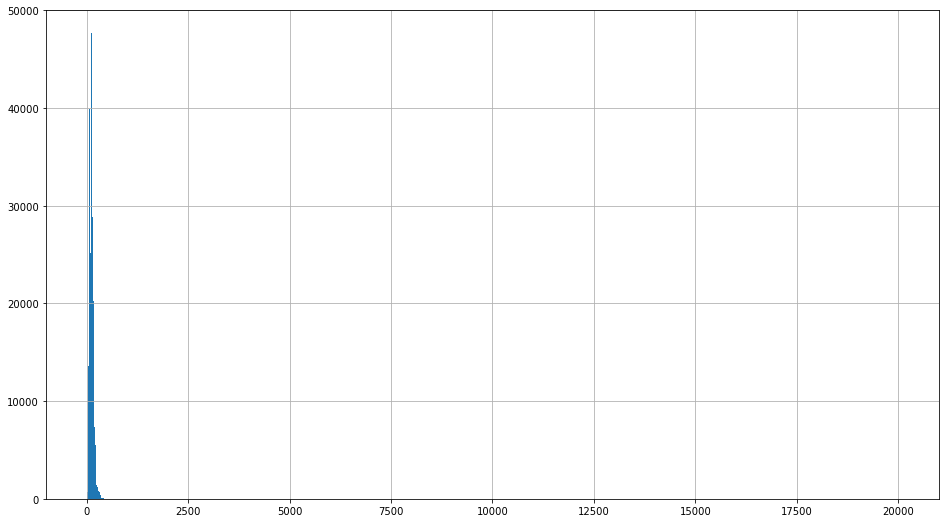

In [40]:
df_filtered5.Power.hist(bins=1000, figsize=(16,9))
df_filtered5.Power.describe()

The spread of values is very strong, so we will discard all values exceeding 1000 hp.

count    225578.000000
mean        119.917470
std          52.000296
min           1.000000
25%          80.000000
50%         111.000000
75%         147.000000
max        1000.000000
Name: Power, dtype: float64

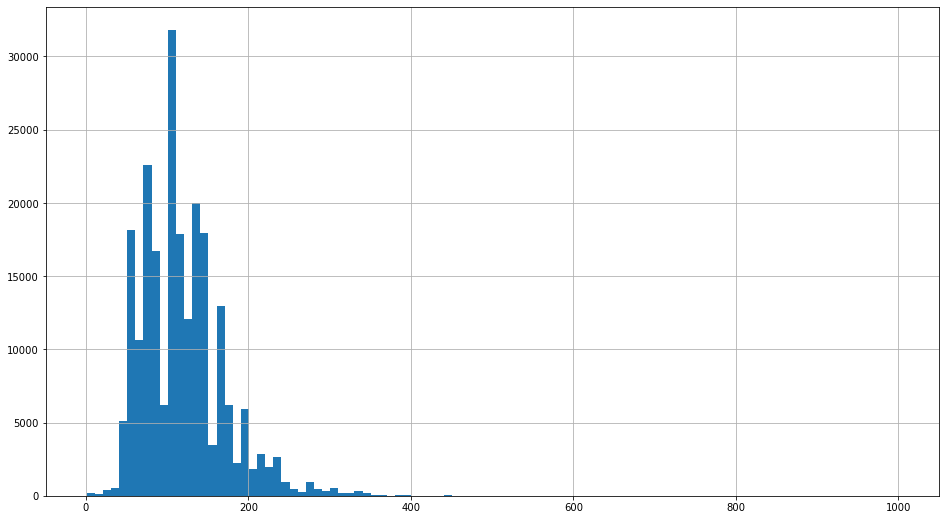

In [41]:
df_filtered6 = df_filtered5.query('0 < Power < 1001')
df_filtered6.Power.hist(bins=100, figsize=(16,9))
df_filtered6.Power.describe()

Let's leave 95% of the values, discarding outliers on the left and right (2.5 quantile = 50 hp, 97.5 - 235 hp).

count    213377.000000
mean        117.540841
std          42.016719
min          51.000000
25%          82.000000
50%         112.000000
75%         143.000000
max         234.000000
Name: Power, dtype: float64

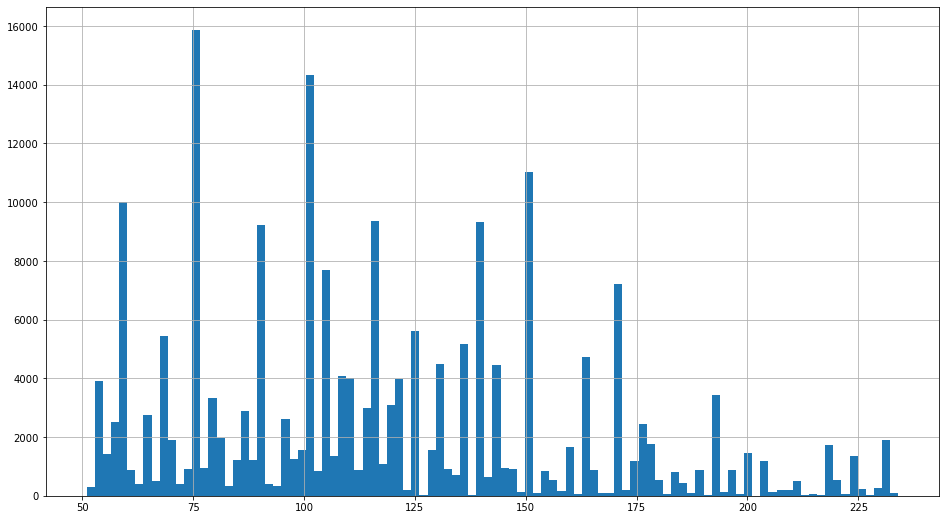

In [42]:
df_filtered6 = df_filtered6.query('50 < Power < 235')
df_filtered6.Power.hist(bins=100, figsize=(16,9))
df_filtered6.Power.describe()

In [43]:
df_filtered6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213377 entries, 137244 to 252983
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             213377 non-null  int64 
 1   VehicleType       213377 non-null  object
 2   RegistrationYear  213377 non-null  int64 
 3   Gearbox           213377 non-null  object
 4   Power             213377 non-null  int64 
 5   Model             213377 non-null  object
 6   Kilometer         213377 non-null  int64 
 7   FuelType          213377 non-null  object
 8   Brand             213377 non-null  object
 9   NotRepaired       213377 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.9+ MB


In order to further apply the algorithms, replace the Gearbox and NotRepaired columns with a Boolean type, where:

* in the column Is Manual Gearbox: 1 - manual (manual transmission), 0 - auto(automatic);
* in the column Is Not Repaired: 1 - means a car without repair, 0 - with repair.

In [44]:
df_filtered6['IsManualGearbox'] = 0
df_filtered6.loc[df_filtered6['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
df_filtered6.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,IsManualGearbox
137244,450,sedan,2000,auto,170,mondeo,150000,petrol,ford,no,0
25246,9900,sedan,2007,auto,177,3er,150000,gasoline,bmw,no,0
77968,3900,small,2010,manual,75,2_reihe,90000,petrol,peugeot,no,1
241038,700,sedan,1993,manual,90,80,150000,petrol,audi,no,1
99878,990,small,1998,manual,75,other,150000,petrol,toyota,no,1


In [45]:
df_filtered6.IsManualGearbox.value_counts()

1    173036
0     40341
Name: IsManualGearbox, dtype: int64

In [46]:
df_filtered6['IsNotRepaired'] = 0
df_filtered6.loc[df_filtered6['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
df_filtered6.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,IsManualGearbox,IsNotRepaired
137244,450,sedan,2000,auto,170,mondeo,150000,petrol,ford,no,0,0
25246,9900,sedan,2007,auto,177,3er,150000,gasoline,bmw,no,0,0
77968,3900,small,2010,manual,75,2_reihe,90000,petrol,peugeot,no,1,0
241038,700,sedan,1993,manual,90,80,150000,petrol,audi,no,1,0
99878,990,small,1998,manual,75,other,150000,petrol,toyota,no,1,0


In [47]:
df_filtered6['IsNotRepaired'].value_counts()

0    183965
1     29412
Name: IsNotRepaired, dtype: int64

Let's delete unnecessary columns.

In [48]:
df_filtered6.drop(['NotRepaired', 'Gearbox'], inplace=True, axis=1)
df_filtered6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213377 entries, 137244 to 252983
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             213377 non-null  int64 
 1   VehicleType       213377 non-null  object
 2   RegistrationYear  213377 non-null  int64 
 3   Power             213377 non-null  int64 
 4   Model             213377 non-null  object
 5   Kilometer         213377 non-null  int64 
 6   FuelType          213377 non-null  object
 7   Brand             213377 non-null  object
 8   IsManualGearbox   213377 non-null  int64 
 9   IsNotRepaired     213377 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 17.9+ MB


<div style="font-size: 20px">
    

**Intermediate conclusion:**

Based on the results of preprocessing, missing values, outliers and anomalies in all columns of the original dataframe were considered and processed. Columns suitable for further training of models and making predictions have been left. The categorical features in the Gearbox and NotRepaired columns were replaced with numerical ones. The data obtained can be used for further research.

## 2. Model training

Let's train the following models:

* * Linear Regression;
* * Decision Tree Regressor;
* CatBoostRegressor;
* LGBMRegressor.

We will use MSE as a metric for all models, and in the final table we will use RMSE. We will check the quality of the models for cross validation.

It is necessary to prepare three types of features for cross validation:

* Source - original_features;
* Encoded by the OHA - oha_features method;
* Encoded by the OE -ordinal_features method.

In [49]:
# Initial and target features 
original_features = df_filtered6.drop('Price', axis=1)
target = df_filtered6['Price']

# Direct coding
encoder = OrdinalEncoder()
categ_columns = ['VehicleType', 'FuelType', 'Brand', 'Model']
categ_features = original_features[categ_columns]
categ_features = pd.DataFrame(encoder.fit_transform(categ_features),
                             columns=categ_features.columns,
                             index=categ_features.index)
ordinal_features = original_features.copy()
for column in categ_columns:
    ordinal_features[column] = categ_features[column]

# OHE
ohe_features = pd.get_dummies(original_features, drop_first=True)


In [50]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
original_features, target, test_size=0.25, random_state=69)

ordinal_features_train = ordinal_features.loc[original_features_train.index,:]
ordinal_features_test = ordinal_features.loc[original_features_test.index,:]

ohe_features_train = ohe_features.loc[original_features_train.index,:]
ohe_features_test = ohe_features.loc[original_features_test.index,:]

<div style="font-size: 20px">
    

**2.1 Linear regression**

In [51]:
%%time

linear_model = LinearRegression()
print('-- Training for RMSE --')
print()
CV_LR_RMSE = (cross_val_score(linear_model,
                             ohe_features_train,
                             target_train,
                             cv=5,
                             scoring='neg_mean_squared_error').mean() * -1) **0.5
print('Average result of RMSE metric from CV for LinearRegression = ', CV_LR_RMSE)

-- Training for RMSE --

Average result of RMSE metric from CV for LinearRegression =  2079.36856279619
Wall time: 14.9 s


In [52]:
%%time

linear_model2 = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard scaller", scaller),("linear_regression", linear_model2)])
print('-- Training for RMSE --')
print()
CV_LR_RMSE_2 = (cross_val_score(pipeline,
                               ohe_features_train,
                               target_train,
                               cv=5,
                               scoring='neg_mean_squared_error').mean() * -1) **0.5
print('Average result of RMSE metric from CV for LinearRegression2 = ', CV_LR_RMSE_2)

-- Training for RMSE --

Average result of RMSE metric from CV for LinearRegression2 =  3902817698301.764
Wall time: 23.2 s


Scaling features degrades the model. We will not use it in the future.

<div style="font-size: 20px">
    

**2.2 DecisionTreeRegressor**

Let's check the model on features:

1. Encoded by the OHE method;
2. Encoded by the OEM method.

In [53]:
%%time

tree_model1 = DecisionTreeRegressor()
max_depth_list = [x for x in range(2,35)]
hyperparams = [{'criterion':['mse'],
               'max_depth':max_depth_list,
               'random_state':[69]}]
print('--Selection of parameters for RMSE--')
print()
clf = GridSearchCV(tree_model1, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print('Best parameters')
print()
print(clf.best_params_)
print()
print("Grid scores")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)**0.5, params))
print()

CV_DTR_RMSE_1 = (max(means)*-1)**0.5

--Selection of parameters for RMSE--

Best parameters

{'criterion': 'mse', 'max_depth': 15, 'random_state': 69}

Grid scores

2510.753198 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 69}
2245.046964 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 69}
2069.910987 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 69}
1958.556893 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 69}
1870.385481 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 69}
1793.205840 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 69}
1735.224222 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 69}
1687.550669 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 69}
1644.046337 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 69}
1607.268046 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 69}
1580.028499 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 69}
1562.622183 for {'criterion': 'mse', 'max_depth': 13, 'random_state

In [54]:
%%time

tree_model2 = DecisionTreeRegressor()
max_depth_list = [x for x in range(2,35)]
hyperparams = [{'criterion':['mse'],
               'max_depth':max_depth_list,
               'random_state':[69]}]

print('--Selection of parameters for MSE--')
print()
clf = GridSearchCV(tree_model2, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print('--Best parameters--')
print()
print(clf.best_params_)
print()
print('Grid scores')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"%((mean*-1)**0.5, params))
print()

CV_DTR_RMSE_2 = (max(means)*-1) ** 0.5

--Selection of parameters for MSE--

--Best parameters--

{'criterion': 'mse', 'max_depth': 13, 'random_state': 69}

Grid scores

2510.753198 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 69}
2245.046964 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 69}
2075.296880 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 69}
1968.167113 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 69}
1875.675629 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 69}
1799.466851 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 69}
1731.890009 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 69}
1681.992259 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 69}
1640.024274 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 69}
1609.087308 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 69}
1589.240078 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 69}
1576.781859 for {'criterion': 'mse', 'max_depth': 13, 'random_st

Training on OHE and OE gave similar results, so we will include them in the final table.

<div style="font-size: 20px">
    

**2.3 CatBoostRegressor**

Let's train the model on the data:

1. encoded by the OE method;
2. on the original data with the indication of categories.

In [55]:
%%time

cat_model = CatBoostRegressor()
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
               'random_state':[69],
               'verbose':[False]}]

print('--Selection of parameters for MSE--')
print()
clf = GridSearchCV(cat_model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print('--Best parameters--')
print()
print(clf.best_params_)
print()
print('Grid scores')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1) ** 0.5, params))
print()

CV_CBR_RMSE_1 = (max(means)*-1) ** 0.5

--Selection of parameters for MSE--

--Best parameters--

{'learning_rate': 0.5, 'random_state': 69, 'verbose': False}

Grid scores

1337.013322 for {'learning_rate': 0.1, 'random_state': 69, 'verbose': False}
1331.258816 for {'learning_rate': 0.5, 'random_state': 69, 'verbose': False}
1353.408219 for {'learning_rate': 0.8, 'random_state': 69, 'verbose': False}

Wall time: 2min 58s


In [56]:
%%time 

cat_model2 = CatBoostRegressor(learning_rate=0.5,
                              iterations=200,
                              random_state=69,
                              verbose=False,
                              cat_features=['VehicleType', 'FuelType', 'Brand', 'Model'])
print('--Training for MSE--')
print()
CV_CBR_RMSE_2 = (cross_val_score(cat_model2,
                                original_features_train,
                                target_train,
                                cv=5,
                                scoring='neg_mean_squared_error').mean()*-1)** 0.5
print('Average value of RMSE for CatBoostRegressor = ', CV_CBR_RMSE_2)

--Training for MSE--

Average value of RMSE for CatBoostRegressor =  1351.2445228041613
Wall time: 1min 16s


<div style="font-size: 20px">
    

**2.4 LGBMRegressor**

In [57]:
%%time 

regressor = LGBMRegressor()
hyperparams = [{'num_leaves':[31, 100, 200],
               'learning_rate':[0.1, 0.3, 0.5],
               'random_state':[69]}]

print('--Selection of parameters for MSE--')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("--Best parameters--")
print()
print(clf.best_params_)
print()
print("Grid scores")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)**0.5, params))
print()

CV_LGBMR_RMSE = (max(means) * -1) **0.5

--Selection of parameters for MSE--

--Best parameters--

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 69}

Grid scores

1396.224790 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 69}
1342.801339 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 69}
1324.692475 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 69}
1355.531136 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 69}
1335.002270 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 69}
1332.178646 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 69}
1360.001086 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 69}
1353.935467 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 69}
1361.789589 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 69}

Wall time: 43.6 s


<div style="font-size: 20px">
    

**Intermediate conclusion:**

In this section, 4 regression models were trained, as well as the best hyperparameters were selected, the training and/or selection time was estimated.

## 3. Analysis of models

We will train models with the best parameters and build forecasts.

<div style="font-size: 20px">
    

**3.1 Linear regression**

In [58]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

Wall time: 3.27 s


LinearRegression()

In [59]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 194 ms


In [60]:
LR_final_RMSE = mean_squared_error(target_test, target_predict) ** 0.5

<div style="font-size: 20px">
    

**3.2 DecisionTreeRegressor**

In [61]:
%%time

model = DecisionTreeRegressor(criterion='mse',
                             max_depth=15,
                             random_state=69)
model.fit(ohe_features_train, target_train)

Wall time: 4.96 s


DecisionTreeRegressor(max_depth=15, random_state=69)

In [62]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 114 ms


In [63]:
DTR_OHE_RMSE_final = mean_squared_error(target_test, target_predict)**0.5

In [64]:
%%time

model = DecisionTreeRegressor(criterion='mse',
                             max_depth=13,
                             random_state=69)
model.fit(ordinal_features_train, target_train)

Wall time: 387 ms


DecisionTreeRegressor(max_depth=13, random_state=69)

In [65]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 20.1 ms


In [66]:
DTR_ORDINAL_RMSE_final = mean_squared_error(target_test, target_predict) ** 0.5

<div style="font-size: 20px">
    

**3.3 CatBoostRegressor**

In [67]:
%%time

model = CatBoostRegressor(learning_rate=0.5,
                         random_state=69,
                         verbose=False)
model.fit(ordinal_features_train, target_train)

Wall time: 13.4 s


In [68]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 29 ms


In [69]:
CBR_ORDINAL_RMSE_final = mean_squared_error(target_test, target_predict) ** 0.5

In [70]:
%%time

model = CatBoostRegressor(learning_rate=0.5,
                          iterations=200,
                          random_state=69,
                          verbose=False,
                          cat_features=['VehicleType','FuelType', 'Brand', 'Model'])
model.fit(original_features_train, target_train)

Wall time: 19.5 s


In [71]:
%%time

target_predict = model.predict(original_features_test)

Wall time: 105 ms


In [72]:
CBR_ORIGINAL_RMSE_final = mean_squared_error(target_test, target_predict) ** 0.5

<div style="font-size: 20px">
    

**3.4 LGBMTreeRegressor**

In [73]:
%%time 

model = LGBMRegressor(learning_rate=0.1,
                     num_leaves=200,
                     random_state=69)
model.fit(ordinal_features_train, target_train)

Wall time: 1.42 s


LGBMRegressor(num_leaves=200, random_state=69)

In [74]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 171 ms


In [75]:
LGBMR_RMSE_final = mean_squared_error(target_test, target_predict) ** 0.5

We display the totals in a single table.

In [76]:
indexes = ['LinearRegression',
           'DecisionTreeRegressor on OHE features',
           'DecisionTreeRegressor on OE features',
           'CatBoostRegressor on OE features',
           'CatBoostRegressor on original features',
           'LGBMRegressor']
data = {'RMSE on CV, euro': [CV_LR_RMSE,
                             CV_DTR_RMSE_1,
                             CV_DTR_RMSE_2,
                             CV_CBR_RMSE_1,
                             CV_CBR_RMSE_2,
                             CV_LGBMR_RMSE],
       'CV training time, sec':[84,
                                    94,
                                    656,
                                    65,
                                    539,
                                    215,
                                    ],
        'RMSE models on the test sample, euro':[LR_final_RMSE,
                                                 DTR_OHE_RMSE_final,
                                                 DTR_ORDINAL_RMSE_final,
                                                 CBR_ORDINAL_RMSE_final,
                                                 CBR_ORIGINAL_RMSE_final,
                                                 LGBMR_RMSE_final],
        'Model training time, sec':[3.48,
                                      5.01,
                                      0.398,
                                      13.6,
                                      19.5,
                                      1.45
                                     ],
        'Model prediction time, sec':[0.185,
                                          0.121,
                                          0.018,
                                          0.0728,
                                          0.0956,
                                          0.256
                                         ]}

total_scores = pd.DataFrame(data=data, index=indexes)
total_scores['RMSE rating'] = (total_scores['RMSE on CV, euro'].min() /
                              total_scores['RMSE on CV, euro'])
total_scores['Rating of training time'] = (total_scores['Model training time, sec'].min() / 
                              total_scores['Model training time, sec'])
total_scores['Rating of predictions time'] = (total_scores['Model prediction time, sec'].min() / 
                              total_scores['Model prediction time, sec'])
total_scores['Final rating'] = (total_scores['RMSE rating'] +
                                   total_scores['Rating of training time'] +
                                   total_scores['Rating of predictions time'])
total_scores

,"RMSE on CV, euro","CV training time, sec","RMSE models on the test sample, euro","Model training time, sec","Model prediction time, sec",RMSE rating,Rating of training time,Rating of predictions time,Final rating
LinearRegression,2079.368563,84,2077.773033,3.480,0.1850,0.637065,0.114368,0.097297,0.848730
DecisionTreeRegressor on OHE features,1550.108160,94,1530.734320,5.010,0.1210,0.854581,0.079441,0.148760,1.082782
DecisionTreeRegressor on OE features,1576.781859,656,1560.137935,0.398,0.0180,0.840124,1.000000,1.000000,2.840124
CatBoostRegressor on OE features,1331.258816,65,1326.370895,13.600,0.0728,0.995068,0.029265,0.247253,1.271585
CatBoostRegressor on original features,1351.244523,539,1339.827530,19.500,0.0956,0.980350,0.020410,0.188285,1.189045
LGBMRegressor,1324.692475,215,1318.500730,1.450,0.2560,1.000000,0.274483,0.070312,1.344795


<div style="font-size: 20px">
    

**4. Final conclusions**

Under this project, data from aftermarket cars were reviewed and preprocessed. Gaps have been filled in, outliers have been removed. Hyperparameters for various machine learning models are considered and selected: LinearRegression, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor.

A relative rating (based on RMSE, training time, and prediction time) was created for the overall assessment of three parameters. Based on the results of the combined rating:

The regressor with the lowest time or RMSE gets the 1st place. The rest receive a rating as the ratio of the best in the column to its value. We believe that all parameters are equivalent.

The choice of the model was not affected by the training time for cross-validation, since it is carried out once on one type of data. At that time, it is necessary to retrain the model on new data much more often.

The best model for the three parameters quality, learning speed and prediction speed can be considered a DecisionTreeRegressor. The speed of learning on the prepared data brings him to the leaders of the rating. Accuracy is generally worse.

If we consider only the estimation of accuracy, then LGBMRegressor takes the lead. It is followed by CatBoostRegressor and DecisionTreeRegressor takes third place.

LinearRegression and Ridge performed very poorly on this task.

Based on the rating obtained, it is possible to identify the specifics of the tasks for regressors.

For quick decisions with good accuracy, a DecisionTreeRegressor with prepared attributes is suitable.
If accuracy is important in the case and there is time, the LGBMRegressor will help predict the best.
For tasks that do not require strong preprocessing and data harvesting, CatBoostRegressor can show itself not bad.